In [1]:
import reeds_shepp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import dubins
from spline_math import *
from obstacle_maneuvre import *
import pandas as pd
import sys
import os
#%matplotlib notebook
%matplotlib inline 
#%matplotlib qt 



In [2]:
sys.path.append(os.getcwd() + "/ReedsSheppPath")
sys.path.append(os.getcwd() + "/HybridAStar")

try:
    from dynamic_programming_heuristic import calc_distance_heuristic
    import reeds_shepp_path_planning as rs
    from car import move, check_car_collision, WB, plot_car
    from hybrid_a_star import *
    from rs_elements import *
except Exception:
    raise

In [3]:
yaw = 40*np.pi/180
rot = Rot.from_euler('z', yaw).as_matrix()[0:2, 0:2]
dir = rot@np.array([1, 0])

In [4]:
indexes = [2,3,1]
s = ["a", "b", "c", "d"]
q = [(ind, s[ind]) for ind in indexes]
q

[(2, 'c'), (3, 'd'), (1, 'b')]

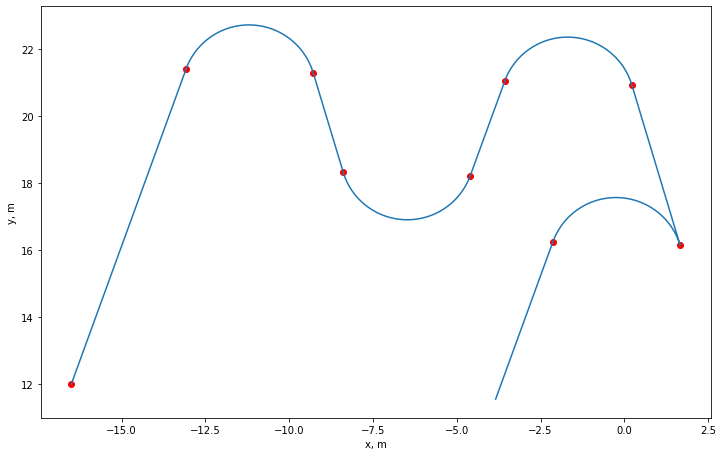

In [5]:
start = [-16.5, 12, np.deg2rad(70.0)]
trajectory_types = [["s",10], ["r",5], ["s", 3.1], ["l",5], ["s", 3,1], ["r", 5],  ["s", 5], ["r", -5], ["s", -5]]
trajectory_real = make_rs_path(0.1,trajectory_types,0.5, start)
trajectory_points_real = trajectory_real.path_points

fig = plt.figure(figsize = (12,12))
plt.plot(trajectory_points_real[:,0], trajectory_points_real[:,1])
for elem in trajectory_real.rs_elements:
    plt.scatter(elem.start_point[0],elem.start_point[1], c='r')

plt.xlabel("x, m")
plt.ylabel("y, m")
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

In [5]:
rs_element = RS_element()
rs_element.start_point = [-17.5, 13, 0.34906584]
rs_element.type = "r"
rs_element.length = 4.8


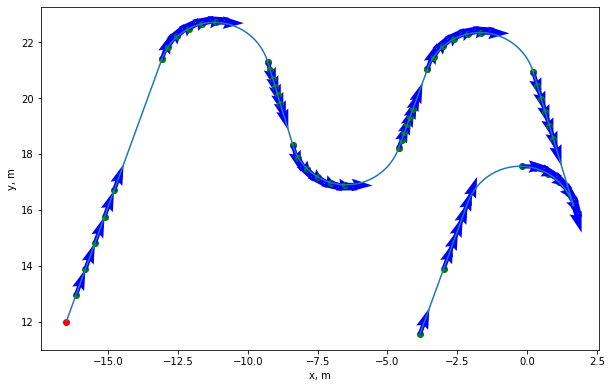

In [11]:
def draw_vector(p, dp): 
    array = np.array([[p[0], p[1], dp[0], dp[1]]])
    X, Y, U, V = zip(*array)
    ax = plt.gca()
    ax.quiver(X, Y, U, V,color='b', angles='xy', scale_units='xy',scale=1)

    
u_max = 0.5

fig = plt.figure(figsize =[10,10])
plt.plot(trajectory_points_real[:,0], trajectory_points_real[:,1])
for elem in trajectory_real.rs_elements:
    plt.scatter(elem.start_point[0],elem.start_point[1], c='r')
for rs_element in trajectory_real.rs_elements:
    for s_star in [0.1, 0.2, 0.3, 0.4, 0.5, 1.0]:
        p, dp = rs_p_dp(rs_element, u_max,s_star)
        plt.scatter(p[0], p[1], c='g')
        draw_vector(p,dp*1)
        #print(p, dp)

plt.xlabel("x, m")
plt.ylabel("y, m")
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

In [8]:
print(p, dp)

[-3.83917719 11.5470528 ] [0.34202014 0.93969262]


In [8]:
def check_point_belong_rs_element(rs_element, u_max, point):
    x_a, N_a = rs_p_dp(rs_element,u_max,0.0)
    x_b, N_b = rs_p_dp(rs_element,u_max,1.0)
    projection1 = N_a.dot(point-x_a)
    projection2 = N_b.dot(point-x_b)
    #print("proj",projection1, projection2)
    if((rs_element.type!="s") and (abs(rs_element.length*rs_element.u)> np.pi)):
        return (projection1*np.sign(rs_element.length) >= 0) or (projection2*np.sign(rs_element.length) <= 0)
    else:
        return (projection1*np.sign(rs_element.length) >= 0) and (projection2*np.sign(rs_element.length) <= 0)


In [92]:
class Control_params(object):       
    def __init__(self, u_max_):
        self.u_max = u_max_
             
    def set_param(self, p, dp, ddp, point, s_star):
        self.ok = True
        self.dp = dp
        self.p = p
        self.ddp = ddp
        self.Delta = point - p  
        self.delta = np.linalg.norm(self.Delta)
        self.s_star = s_star
    def print_all(self):
        print("p", self.p )
        print("dp", self.dp)
        print("ddp", self.ddp)
        print("Delta", self.Delta)
        print("delta", self.delta)
        print("s_star", self.s_star)
        
def find_control_params(rs_element, point):
    u_max = np.abs(rs_element.u)
    if(rs_element.type == 's'): 
        cr = Control_params(0)
    if(rs_element.type == 'r'):
        cr = Control_params(u_max)
    if(rs_element.type == 'l'):
        cr = Control_params(-u_max)
    
    x, y, yaw = rs_element.start_point[0], rs_element.start_point[1], rs_element.start_point[2]
    start_point = np.array([x, y])
    rot = Rot.from_euler('z', yaw).as_matrix()[0:2, 0:2]
    p_derv = np.dot(rot, np.array([1, 0]))
    p_end, dp_end = rs_p_dp(rs_element, u_max, 1.0)
    if(rs_element.type == 's'):
        p =  start_point + p_derv*(p_derv@(point[:2] - start_point))
        ddp = np.array([0, 0])
        dp = p_derv
        fi = p - start_point
        Fi = p_end - start_point
        s_star = np.sign(fi.dot(Fi))*np.linalg.norm(fi)/np.linalg.norm(Fi)
        cr.set_param(p,dp, ddp, point[:2], s_star)
        return cr
    
    normal = np.dot(rot,  np.array([0, 1]))
    if(u_max ==0.0):
        raise
    if(rs_element.type == 'r'):
        center_point = rs_element.start_point[:2] - normal/ u_max
        #ddp = (point - center_point)/np.linalg.norm(point - center_point)/u_max
            
    if(rs_element.type == 'l'):
        center_point = rs_element.start_point[:2] + normal/ u_max
    ddp = (center_point - point)/np.linalg.norm(point - center_point)/u_max
    p = center_point + (point - center_point)/np.linalg.norm(point - center_point)/u_max
    
    v_p = point - center_point
    v_start = start_point - center_point
    v_end = p_end - center_point
    
    fi = np.arccos(np.dot(v_p, v_start)/(np.linalg.norm(v_p)*np.linalg.norm(v_start)))
    Fi = np.arccos(np.dot(v_start, v_end)/(np.linalg.norm(v_start)*np.linalg.norm(v_end)))
    print("fi Fi ",fi, Fi)
    s_star = abs(fi/Fi)#*np.sign(np.linalg.norm(np.cross(v_p, v_start))*np.linalg.norm(np.cross(v_start, v_end)))
    plt.scatter(center_point[0], center_point[1])
    #print("center_point", center_point)
    #print("p_derv", p_derv)
    #print("start_point", start_point)
    dp = np.array([0, 1])
    cr.set_param(p, dp, ddp, point, s_star)
    return cr


ok
p [-13.27228317  12.79381581]
dp [0 1]
ddp [-1.35150208 -1.47425986]
Delta [-0.72771683 -0.79381581]
delta 1.076900792916409
s_star 0.963713572942664


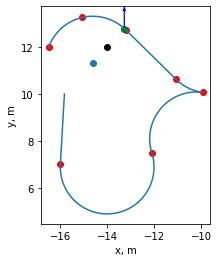

In [93]:
start = [-16.5, 12, np.deg2rad(70.0)]

u_max = 0.5
trajectory_types = [["s",10, 0], ["r",5, u_max], ["s", 3.1,0], ["l",5, u_max], ["s", 3,1, 0], ["r", 5, u_max],  ["s", 5, 0], ["r", -5, u_max], ["s", -5, 0]]
trajectory_types = [["r", 2, u_max],["r", 2, u_max],["s",3, 0],["l",1.3, u_max], ["r", -4, u_max], ["l", -7, u_max], ["s", -3, 0]]

trajectory_real = make_trajectory(trajectory_types, start)
trajectory_points_real = trajectory_real.path_points

plt.plot(trajectory_points_real[:,0], trajectory_points_real[:,1])
for elem in trajectory_real.rs_elements:
    plt.scatter(elem.start_point[0],elem.start_point[1], c='r')
 
u_max = 0.5

#point = rs_p_dp(rs_element, 1.0)[0]+ (np.random.normal(0,1))
point = np.array([-14, 12])
ind = 1

# point = np.array([-15, 9.4])
# ind = 1

# point = np.array([-18, 9.0])
# ind = 2


# point = np.array([-18, 9.0])
# ind = 3

# point = np.array([-19, 13.0])
# ind = 4

# point = np.array([-15, 14.0])
# ind = 5

rs_element = trajectory_real.rs_elements[ind]

if(check_point_belong_rs_element(rs_element,u_max, point)):
    print("ok")
else:
    print("bad")


cr = find_control_params(rs_element, point)
plt.scatter(point[0], point[1],c = 'k')
plt.scatter(cr.p[0], cr.p[1],c = 'g')
draw(cr.p, cr.dp)

plt.xlabel("x, m")
plt.ylabel("y, m")
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()
cr.print_all()

In [94]:
def calculateCtrlOut(pos, cr, lambda_, rs_element, line = False):
    norm_ps = 1
    rot = Rot.from_euler('z', pos[2]).as_matrix()[0:2, 0:2]   
    Ce = np.dot(rot, np.array([1, 0])) 
    if(rs_element.length<0):
        Ce = -Ce   
    Delta_pss = -abs(cr.delta*rs_element.u)
    #Delta_pss = cr.Delta.dot(cr.ddp)
    cosPhi = cr.Delta.dot(Ce) / cr.delta
    sinPhi = np.sqrt(1.0-cosPhi*cosPhi)
    crossSign = 1
    Delta = np.array([cr.Delta[0],cr.Delta[1],0])
    Ce = np.array([Ce[0],Ce[1],0])
    if (np.cross(Ce,Delta)[2] < 0.0):
        crossSign = -1
    u = -crossSign*(cr.delta*lambda_*lambda_ + 2*lambda_*cosPhi + (Delta_pss*sinPhi*sinPhi)/(cr.delta*(-1 + Delta_pss)))/sinPhi
    if(rs_element.length<0):
        u = -u
    #print("u", u)
    return u


True


Text(0, 0.5, 'y, m')

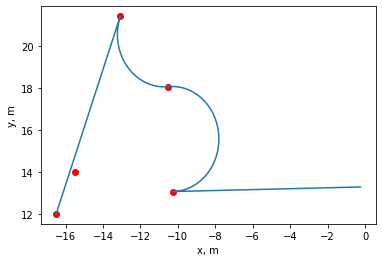

In [95]:
start = [-16.5, 12, np.deg2rad(70.0)]
start_point = [-15.5, 14, np.deg2rad(70.0)]
u_max = 0.4
trajectory_types = [["s",10]]
trajectory_types = [["s",10, u_max], ["r",-5, u_max], ["l",-8, u_max], ["s", 10, u_max]]
trajectory = make_trajectory(trajectory_types, start)
trajectory_points = trajectory.path_points
plt.plot(trajectory_points[:,0], trajectory_points[:,1])
plt.scatter(start_point[0],start_point[1], c='r')
for elem in trajectory.rs_elements:
    plt.scatter(elem.start_point[0],elem.start_point[1], c='r')
    
rs_element = trajectory.rs_elements[0]
print(check_point_belong_rs_element(rs_element, u_max, start_point[:2]))

plt.xlabel("x, m")
plt.ylabel("y, m")
#plt.gca().set_aspect('equal', adjustable='box')
#plt.draw()


In [96]:

def make_smooth_trajectory(elem_types, start, n, l):
    def make_rs_elem(rs_elem, x, y, yaw):
        elem = RS_element()
        elem.type = rs_elem[0]
        elem.length = rs_elem[1]
        #elem.u = rs_elem[2]
        elem.u = np.abs(rs_elem[2])
        elem.start_point = [x,y, yaw]
        
        if(elem.type =="r"):
            u = - elem.u
        elif(elem.type =="l"):
            u =  elem.u
        else:
            u = 0

        length = 0
        while length <  abs(elem.length):
            x,y, yaw = move(x, y, yaw, RESOLUTION*np.sign(rs_elem[1]), u)
            length+=RESOLUTION
            path_point.append([x,y, yaw ])
        return elem,x,y,yaw
    
    path_point = [start]
    x, y, yaw = start
    trajectory_types = elem_types
    trajectory = Path()
    
    for ii, rs_elem in enumerate(trajectory_types):
        if(ii ==0):
            elem,x,y,yaw = make_rs_elem(rs_elem, x, y, yaw)
        else:
    
            if(rs_elem[0]!=elem.type and np.sign(rs_elem[1]) == np.sign(elem.length)):
                u_list = np.linspace(elem.u, rs_elem[2], n)[1:n-1]
                for u in u_list:
                    if(rs_elem[0] == 's'):
                        type_new = elem.type
                    else:
                        type_new = rs_elem[0] 
                        
                    rs_elem_new = [type_new, np.sign(rs_elem[1])*l, u]
                    elem,x,y,yaw = make_rs_elem(rs_elem_new, x, y, yaw)
                    trajectory.rs_elements.append(elem)

            elem,x,y,yaw = make_rs_elem(rs_elem, x, y, yaw)
            
        trajectory.rs_elements.append(elem)
        
        
    path_point = np.array(path_point)  
    trajectory.path_points = path_point
    return trajectory

s_star 0.0034150635094613298
s_star 0.023415063509460907
s_star 0.043414785700381625
s_star 0.06341478525577486
s_star 0.08341400355133521
s_star 0.10341400087670245
s_star 0.12341328189390317
s_star 0.1434132814520715
s_star 0.1634127064528295
s_star 0.18341269316724296
s_star 0.2034122485251386
s_star 0.22341220857863334
s_star 0.24341185923542222
s_star 0.2634117883952045
s_star 0.2834115031869158
s_star 0.3034114042680939
s_star 0.3234111607514773
s_star 0.34341103946819074
s_star 0.3634108226668114
s_star 0.38341068494701125
s_star 0.40341048515756134
s_star 0.4234103359735755
s_star 0.4434101469775883
s_star 0.4634099900766725
s_star 0.48340980790615046
s_star 0.5034096459387031
s_star 0.5234094680685802
s_star 0.5434093028341878
s_star 0.5634091276625326
s_star 0.5834089603496402
s_star 0.6034087868640035
s_star 0.6234086182421943
s_star 0.643408445805456
s_star 0.6634082763659583
s_star 0.6834081045790303
s_star 0.7034079346320067
s_star 0.7234077632460539
s_star 0.743407592985

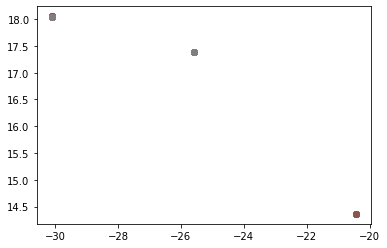

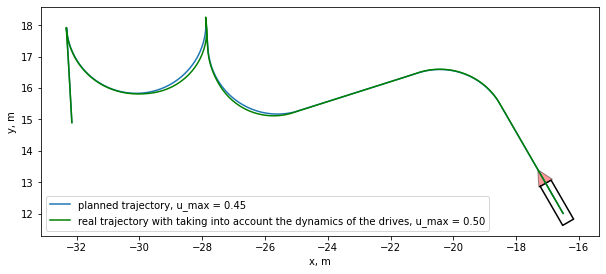

In [100]:

def pi_2_pi(angle):
    pi = np.pi
    return (angle + pi) % (2 * pi) - pi

def move(x, y, yaw, distance, u):
    x += distance * cos(yaw)
    y += distance * sin(yaw)
    yaw = pi_2_pi(yaw + distance * u)
    return x, y, yaw

chord_len = 0
def get_rs_element_ind(trajectory,u_max, ind_previous, point, delta):
    
    if (ind_previous == len(trajectory.rs_elements)-1):
        #print(f"END OF ROUTE")
        rs_element = trajectory.rs_elements[ind_previous]
        if(check_point_belong_rs_element(rs_element,u_max, point)):
            return ind_previous
        
        return -100

        
    
    rs_element = trajectory.rs_elements[ind_previous]
#     global chord_len
#     chord_len+=abs(delta)
#     l = rs_element.length
#     if(chord_len>=l*0.5):
#         if(check_point_belong_rs_element(rs_element, u_max,point) == False):
#             chord_len = 0
#             return ind_previous+1
   
    cr = find_control_params(rs_element, pos[:2])
    print("s_star",cr.s_star)
    if(cr.s_star>=1):
        return ind_previous+1

    return ind_previous
        
U_TRAJECTORY = 0.45
U_ROBOT = 0.50

start = [-16.5, 12, np.deg2rad(120.0)]

"""
trajectory_types = [["s",10, U_TRAJECTORY], ["r",5, U_TRAJECTORY], 
                    ["s", 1.1,U_TRAJECTORY], ["l",2, U_TRAJECTORY],
                    ["s", 1.1, U_TRAJECTORY], ["r", 5, U_TRAJECTORY],  
                    ["s", 5, U_TRAJECTORY], ["r", -5, U_TRAJECTORY], ["s", -5,U_TRAJECTORY]]
"""
# trajectory_types = [["s",10, 0], ["r",5, U_TRAJECTORY], 
#                      ["l",2, U_TRAJECTORY], ["r", 1, U_TRAJECTORY],  
#                     ["s", 5, 0], ["r", -5, U_TRAJECTORY], ["s", -5,0]]


trajectory_types = [["s", 4.0, 0], ["l",3, U_TRAJECTORY],["s", 4.0, 0], ["r", 4, U_TRAJECTORY], ["s", 1.0, 0], ["l", -4, U_TRAJECTORY],  ["l", -3, U_TRAJECTORY], ["s", 3, 0]]
#trajectory_types = [["s",5, 0], ["r", 4, U_TRAJECTORY],["l",1.3, U_TRAJECTORY], ["r", 4, U_TRAJECTORY], ["l", 7, U_TRAJECTORY], ["s", 3, 0]]

#trajectory_types = [["s",-10], ["r",-5], ["l",-8], ["s", -10]]
trajectory = make_trajectory(trajectory_types, start)

# for elem in trajectory_types:
#     elem[1] = elem[1]*0.5

# n = 20
# trajectory = make_smooth_trajectory(trajectory_types, start, n, 0.2)

trajectory_points = trajectory.path_points
rs_element = trajectory.rs_elements[0]
start_point = start - np.array([0.01,-0.01,0])*np.sign(rs_element.length)
x,y,yaw = start_point
WAY = [start_point]
DELTA = []
ind_prev = 0
U = []
ind = 0
u_real = 0.0
ALFA = 0.1
LAMBDA = 3
V = 0.80
dt = 0.1
OMEGA = U_ROBOT*1.6
MOVEMENT_RESOLUTION = V*dt
T = []
t = 0.0
for i in range(510):
    pos = np.array([x, y, yaw])
    ind_NEXT = get_rs_element_ind(trajectory, U_TRAJECTORY,ind, pos[:2], MOVEMENT_RESOLUTION)
    if(ind!=ind_NEXT):
        ind = ind_NEXT
        print("===================next============================",ind)
    if(ind ==-100):
        print(f"END OF ROUTE {i}")
        break

    #print(ind)
    rs_element = trajectory.rs_elements[ind]
    cr = find_control_params(rs_element, pos[:2])
    if(rs_element.length<0):
        _lambda = LAMBDA
    else:
        _lambda = LAMBDA
        
    u = calculateCtrlOut(pos, cr, _lambda, rs_element, 0)

    u = np.clip(u, -U_ROBOT, U_ROBOT) 
    #u_real = u_real*(1-ALFA) + ALFA*u
    #print("u", u)
    u_real = u + np.clip(u - u_real, -OMEGA*dt,OMEGA*dt)    
    x,y,yaw = move(x,y,yaw, MOVEMENT_RESOLUTION*np.sign(rs_element.length) ,u_real)
    WAY.append([x, y, yaw])
    DELTA.append(cr.delta)
    ind_prev = ind
    U.append(u_real)
    t +=dt
    T.append(t)
   
fig = plt.figure(figsize = (10,10))
plot_car(start_point[0]+0.0, start_point[1] +0.0, start_point[2])
WAY = np.array(WAY)    
U = np.array(U)    
plt.plot(trajectory_points[:,0], trajectory_points[:,1],  label = "planned trajectory, u_max = 0.45")
plt.plot(WAY[:,0], WAY[:,1], c = 'g',  label = "real trajectory with taking into account the dynamics of the drives, u_max = 0.50")
#for elem in trajectory.rs_elements:
#    plt.scatter(elem.start_point[0],elem.start_point[1], c='r')
    

plt.xlabel("x, m")
plt.ylabel("y, m")

plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

In [98]:
ind = 1
print(trajectory.rs_elements[ind].type)

print(trajectory.rs_elements[ind].u)

l
0.45


Text(0, 0.5, 'u, 1/m')

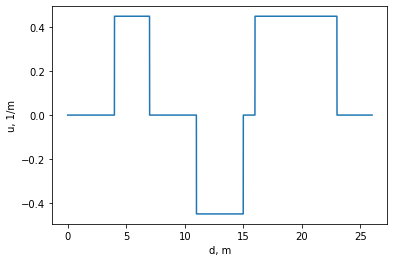

In [84]:
U_ = np.array([])
L =np.array([])
l = 0

for rs_elements in trajectory.rs_elements:
    if(rs_elements.type == 'r'):   
        u = -rs_elements.u
    elif(rs_elements.type == 'l'):   
        u = rs_elements.u
    else:
        u = 0
    U_ = np.hstack((U_, np.array(len(np.arange(l, l+np.abs(rs_elements.length), 0.01))*[u])))
    L = np.hstack((L, np.arange(l, l+np.abs(rs_elements.length),  0.01)))
    l = l+np.abs(rs_elements.length)
plt.plot(L, U_)


plt.xlabel("d, m")
plt.ylabel("u, 1/m")


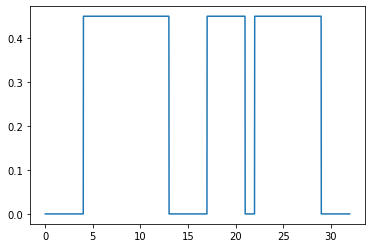

In [29]:
U_ = np.array([])
L =np.array([])
l = 0

for rs_elements in trajectory.rs_elements:
    u = rs_elements.u
    U_ = np.hstack((U_, np.array(len(np.arange(l, l+np.abs(rs_elements.length), 0.01))*[u])))
    L = np.hstack((L, np.arange(l, l+np.abs(rs_elements.length),  0.01)))
    l = l+np.abs(rs_elements.length)
plt.plot(L, U_)

Text(0, 0.5, 'U, 1/m')

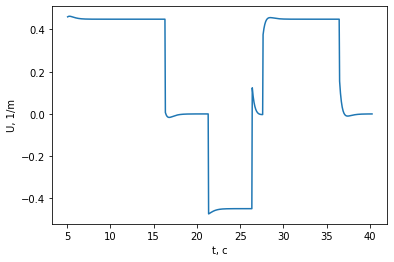

In [30]:
N1 = 100
N2 = 120000
plt.plot(T[N1:N2], U[N1:N2])
plt.xlabel("t, c")
plt.ylabel("U, 1/m")

In [31]:
a = np.array( [0.34202014, 0.93969262])
b = np.array([-0.56162842,  0.20441603])
np.dot(a,b)

3.964319789107051e-09

In [32]:
rs_element.length

3

Text(0, 0.5, 'Delta, m')

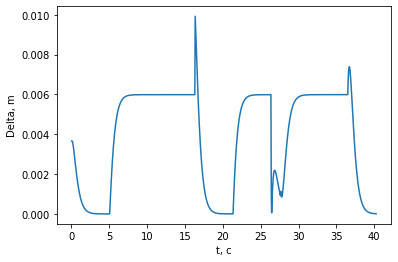

In [33]:
plt.plot(T, DELTA)
plt.xlabel("t, c")

plt.ylabel("Delta, m")

Text(0, 0.5, 'U, 1/m')

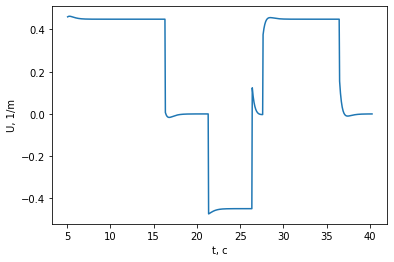

In [34]:
N1 = 100
N2 = 120000
plt.plot(T[N1:N2], U[N1:N2])
plt.xlabel("t, c")
plt.ylabel("U, 1/m")

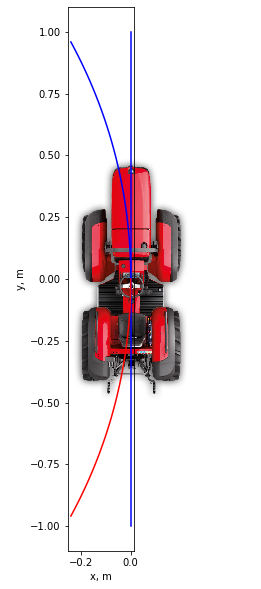

In [41]:

U_TRAJECTORY = 0.5

start = [0, 0, np.deg2rad(90.0)]

l  = 1
type1 = [["r",2, U_TRAJECTORY], ["s", 8, 0],["s",3, 0],["l",1.3, U_TRAJECTORY],["s", 1.0, 0], ["r", 4, U_TRAJECTORY], ["s", 1.0, 0], ["l", 7, U_TRAJECTORY], ["s", 3, 0]]

type1 = [["r",l, U_TRAJECTORY]]

trajectory1 = make_trajectory(type1, start)

type2 = [["s",l, 0]]
trajectory2 = make_trajectory(type2, start)

type3 = [["l", l, U_TRAJECTORY]]
trajectory3 = make_trajectory(type3, start)




type4 = [["s",-l, 0]]
trajectory4 = make_trajectory(type4, start)

type5 = [["r",-l, U_TRAJECTORY]]
trajectory5 = make_trajectory(type5, start)

type6 = [["l",-l, U_TRAJECTORY]]
trajectory6 = make_trajectory(type6, start)

fig = plt.figure(figsize = (10,10))
plot_car(start[0]-0.5, start[1]-0.5, start[2], l = 1)
 
#plt.plot(trajectory1.path_points[:,0], trajectory1.path_points[:,1],  label = "planned trajectory, u_max = 0.4", c = 'b')
plt.plot(trajectory2.path_points[:,0], trajectory2.path_points[:,1],  label = "planned trajectory, u_max = 0.4", c = 'b')
plt.plot(trajectory3.path_points[:,0], trajectory3.path_points[:,1],  label = "planned trajectory, u_max = 0.4", c = 'b')
plt.plot(trajectory4.path_points[:,0], trajectory4.path_points[:,1],  label = "planned trajectory, u_max = 0.4", c = 'b')
#plt.plot(trajectory5.path_points[:,0], trajectory5.path_points[:,1],  label = "planned trajectory, u_max = 0.4", c = 'r')
plt.plot(trajectory6.path_points[:,0], trajectory6.path_points[:,1],  label = "planned trajectory, u_max = 0.4", c = 'r')





plt.xlabel("x, m")
plt.ylabel("y, m")
#plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

In [64]:
def make_rs_elem(rs_elem, start_point, rs_elem_prev = ['r', 1, 0.5]):
    x, y, yaw = start_point
    u_max = np.abs(rs_elem[2])

    if(rs_elem[0] =="r"):
        u = - u_max
    elif(rs_elem[0] =="l"):
        u =  u_max
    else:
        u = 0

    
    if(rs_elem_prev[0] =="r"):
        u_prev = - u_max
    elif(rs_elem_prev[0] =="l"):
        u_prev =  u_max
    else:
        u_prev = 0
    
    length = 0
    path_point = []
    if(u_prev != u):
        print(u_prev, u)
        u_range = np.linspace(u_prev, u, int(abs(rs_elem[1]/RESOLUTION)))
        for u_ in u_range:
            x,y, yaw = move(x, y, yaw, RESOLUTION*np.sign(rs_elem[1]), u_)
            path_point.append([x,y, yaw ])
    else:
        while length <  abs(rs_elem[1]):
            x,y, yaw = move(x, y, yaw, RESOLUTION*np.sign(rs_elem[1]), u)
            length+=RESOLUTION
            path_point.append([x,y, yaw ])
    return np.array(path_point)

def make__simplers_elem(rs_elem, start_point):
    x, y, yaw = start_point
    u_max = np.abs(rs_elem[2])

    if(rs_elem[0] =="r"):
        u = - u_max
    elif(rs_elem[0] =="l"):
        u =  u_max
    else:
        u = 0

    
    if(rs_elem_prev[0] =="r"):
        u_prev = - u_max
    elif(rs_elem_prev[0] =="l"):
        u_prev =  u_max
    else:
        u_prev = 0
    
    length = 0
    path_point = []

    while length <  abs(rs_elem[1]):
        x,y, yaw = move(x, y, yaw, RESOLUTION*np.sign(rs_elem[1]), u)
        length+=RESOLUTION
        path_point.append([x,y, yaw ])
        
    return np.array(path_point)

In [69]:
def calc_next(current):
    if(current[0] == 'r'):
        next_pose = ['r', 's']
    
    if(current[0] == 's'):
        next_pose = ['r', 's', 'l']
        
    if(current[0] == 'l'):
        next_pose = ['s', 'l']
    
    poses = []
    l = 1
    u = 0.5
    
    for t in next_pose:
        for lnth in [-l, l]:
            poses.append([t, lnth, u])
            
    return poses

In [28]:
1/RESOLUTION

100.0

In [46]:
np.arange(0, -0.5, -0.08)

array([ 0.  , -0.08, -0.16, -0.24, -0.32, -0.4 , -0.48])

In [94]:
np.linspace(-0.0, -0.0, 8)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.])

-0.5 0
-0.5 0
0 -0.5
0 -0.5
0 0.5
0 0.5
0.5 0
0.5 0


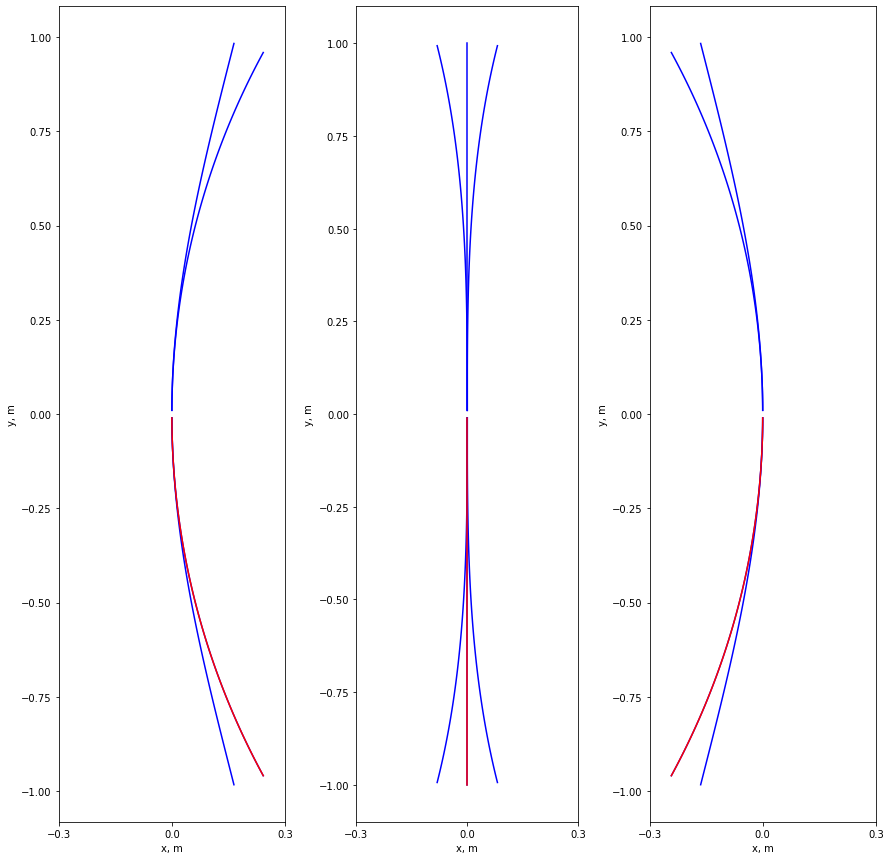

In [95]:

U_TRAJECTORY = 0.5

start = [0, 0, np.deg2rad(90.0)]

l  = 0.8

RS_PREV = [['r', -1, 0.5], ['s', -1, 0.5], ['l', -1, 0.5]]


type1 = ["r",l, U_TRAJECTORY]


fig, axs = plt.subplots(1, 3, figsize = (15, 15))
for ax, rs_elem_prev in zip(axs, RS_PREV):
    for rs_elem in calc_next(rs_elem_prev):
        trajectory = make_rs_elem(rs_elem, start, rs_elem_prev)
        ax.plot(trajectory[:,0], trajectory[:,1],  label = "planned trajectory, u_max = 0.4", c = 'b')
    trajectory = make__simplers_elem(rs_elem_prev, start)
    ax.plot(trajectory[:,0], trajectory[:,1],  label = "planned trajectory, u_max = 0.4", c = 'r')

    ax.set_xticks([-0.3, 0.0,0.3])
    ax.set_xlabel("x, m")
    ax.set_ylabel("y, m")
    #plt.legend()
    ax.set_aspect('equal')
    #ax.gca().set_aspect('equal', adjustable='box')
    #plt.draw()

In [75]:
axs

array([<AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:xlabel='x, m', ylabel='y, m'>], dtype=object)